In [30]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import skimage
import scipy
from skimage import transform
import PIL
from PIL import Image
import sklearn
import torch
import torchvision


In [99]:
## Below are the code of "harris.py"
"""
CLAB Task-1: Harris Corner Detector
Your name (Your uniID): u7752658
"""


def conv2(img, conv_filter):
    # flip the filter
    f_siz_1, f_size_2 = conv_filter.shape
    conv_filter = conv_filter[range(f_siz_1 - 1, -1, -1), :][:, range(f_siz_1 - 1, -1, -1)]
    pad = (conv_filter.shape[0] - 1) // 2
    result = np.zeros((img.shape))
    img = np.pad(img, ((pad, pad), (pad, pad)), 'constant', constant_values=(0, 0))
    filter_size = conv_filter.shape[0]
    for r in np.arange(img.shape[0] - filter_size + 1):
        for c in np.arange(img.shape[1] - filter_size + 1):
            curr_region = img[r:r + filter_size, c:c + filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.

    return result


def fspecial(shape=(3, 3), sigma=0.5):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def calculateM(sigma,imageFile):
    # Parameters, add more if needed
    sigma = 2
    

    # Derivative masks
    dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    dy = dx.transpose()

    bw = plt.imread(imageFile)
    if(len(bw.shape)==3):
        bw = cv2.cvtColor(bw,cv2.COLOR_BGR2GRAY)
    bw = np.array(bw * 255, dtype=int)
    # computer x and y derivatives of image
    Ix = conv2(bw, dx)
    Iy = conv2(bw, dy)

    # Gaussian kernel
    g = np.array((
    [1/16, 2/16, 1/16],
    [2/16, 4/16, 2/16],
    [1/16, 2/16, 1/16]), dtype="float64")
    # g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)
    Iy2 = conv2(np.power(Iy, 2), g)
    Ix2 = conv2(np.power(Ix, 2), g)
    Ixy = conv2(Ix * Iy, g)

    return Ix2,Iy2,Ixy

thresh = 0.005
######################################################################
# Task: Compute the Harris Cornerness
######################################################################

#this is for method 1, in which R has real values
def my_harris2(Ix2,Iy2,Ixy,thresh,k):# k=0.01-0.1# empirical constant
    a=np.ones(Ix2.shape)# a in quadratic
    b=-(Ix2+Iy2)# b in quadratic
    c=Ix2*Iy2-Ixy*Ixy# c in quadratic

    lambda1=(-b-np.sqrt(b*b-4.0*a*c))/(2.0)# one solution
    lambda2=(-b+np.sqrt(b*b-4.0*a*c))/(2.0)# the other solution


    detM = lambda1*lambda2# det M
    traceM = lambda1+lambda2# trace M
    R = detM-k*np.power(traceM,2)# computer corner response
    R = R/np.max(R)
    # print('R before thresholding: ',R)
    # find points with large R
    R[R<thresh] = 0
    # print('R after thresholding: ',R)
    # R[R>=thresh] = 1
    return R


def non_maximum_suppression(matrix, kernel_size=2):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))  # rectangular kernel
    maxed_matrix  = cv2.dilate(matrix, kernel)  # get maximum value in the window for each pixel
    non_maximum_suppression_matrix = matrix.copy()
    non_maximum_suppression_matrix[matrix != maxed_matrix] = 0  # set to 0 pixel originally are not local maxima
    return non_maximum_suppression_matrix




## 5.

In [102]:
pic1 = cv2.imread("Task1/Harris-1.jpg")
print(pic1.shape)

(370, 492, 3)


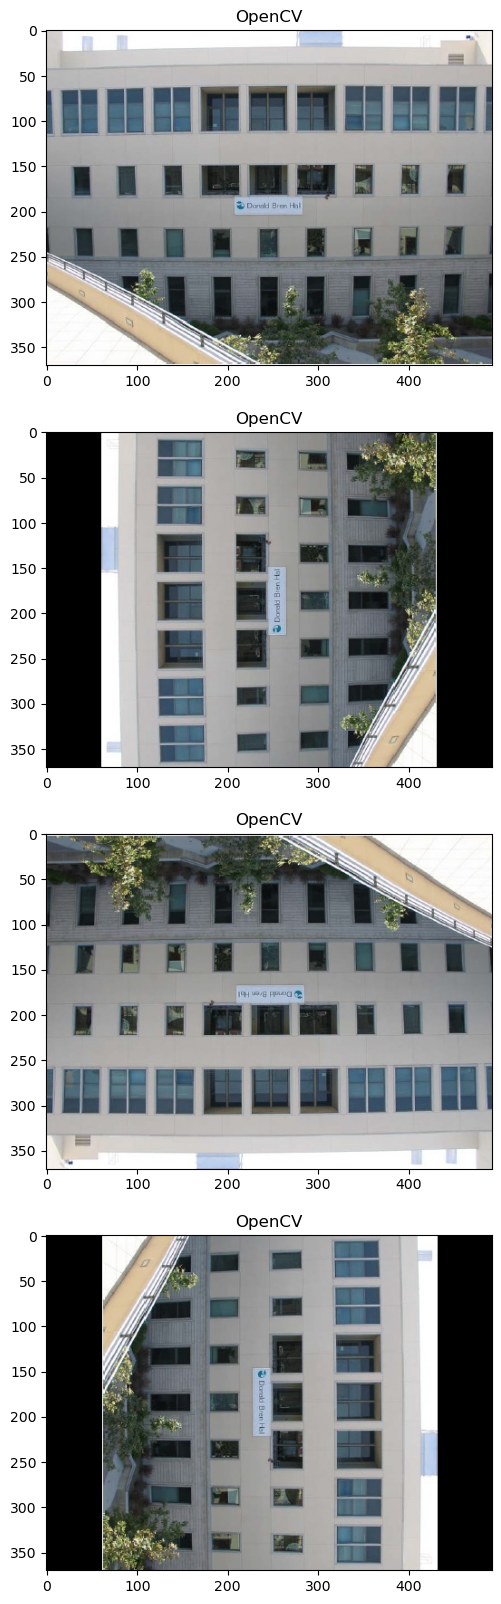

In [143]:
#one method from https://blog.csdn.net/weixin_42398658/article/details/121019668#:~:text=%E4%BB%A3%E7%A0%81%E6%9D%A5%E6%BA%90%EF%BC%9Ahttps%3A%2F%2Fgithub.com%2Fshouxieai%2FtensorRT_Pro%23%20%E5%AE%9E%E7%8E%B0%E4%B8%80%E4%B8%AA%E4%BB%BF%E5%B0%84%E5%8F%98%E6%8D%A2%EF%BC%8C%E9%87%87%E7%94%A8%E5%8F%8C%E7%BA%BF%E6%80%A7%E6%8F%92%E5%80%BC%E6%96%B9%E5%BC%8F%E5%AE%9E%E7%8E%B0%E4%B8%80%E4%B8%AAwarpaffinedef%20pyWarpAffine%20%28image%2C%20M%2C%20dst_size%2C%20constant%3D%20%280%2C0%2C0%29%29%3A,M%20%3D%20cv.invertAffineTransform%20%28M%29%20%23%20%E6%B1%82%E4%BB%BF%E5%B0%84%E5%8F%98%E6%8D%A2%E7%9A%84%E9%80%86%E7%9F%A9%E9%98%B5%EF%BC%8C%E5%9B%A0%E4%B8%BA%E6%88%91%E4%BB%AC%E6%98%AF%E6%8A%8A%E7%9B%AE%E7%9A%84%E5%9B%BE%E7%89%87%E4%BD%9C%E4%B8%BA%E8%BE%93%E5%85%A5%E5%9B%BE%E7%89%87%EF%BC%8C%E5%9B%A0%E6%AD%A4%E9%9C%80%E8%A6%81%E4%BD%BF%E7%94%A8%E9%80%86%E7%9F%A9%E9%98%B5%E6%B1%82%E5%8F%96%E5%8E%9F%E5%A7%8B%E5%9B%BE%E7%89%87%E7%9A%84%E7%82%B9%20cons..._python%20warpaffine
# 实现一个仿射变换，采用双线性插值方式实现一个warpaffine
def pyWarpAffine(image, M, dst_size, constant=(0,0,0)):
    M = cv2.invertAffineTransform(M) # 求仿射变换的逆矩阵，因为我们是把目的图片作为输入图片，因此需要使用逆矩阵求取原始图片的点
    constant = np.array(constant)
    ih,iw = image.shape[:2]
    dw,dh = dst_size
    dst = np.full((dh,dw,3), constant, dtype=np.uint8)
    irange = lambda p:p[0]>=0 and p[0]<iw and p[1]>=0 and p[1]<ih  # 边界判断
 
    # 开始遍历像素点
    # 这里需要确定的是这里为了尽量降低计算量，采用遍历目标图片的像素，显然目标图片的像素大小是确定的，无论输入的图片大小是多大
    # 最后我都会变换到目标图片大小，如输入到深度学习模型的图片应该是640x640，原始图片的大小为1080x1920，显然遍历原始图片的计算很大
    # 遍历目标的图片是固定的且不大，那么这个仿射变换如何做呢？
    # 1. 首先输入的仿射变换矩阵是从原始图片的点--->目标图片的点，因此需要取逆变换获取到从目标图像的点--->原始图片的点
    # 2. 当变换到原始图片的点位置时，将采用双线性变换的方法计算该点在原始位置的像素值
    # 3. 如何计算呢？这里需要想明白，双线的本质是通过四个点的值计算一个点的值，那么变换到原始图片的点就是我们需要求的点值，
    #    这个计算出来的值将直接赋值到目标图片对应位置，但是这四个点如何选取？其实很简单，就取相邻的四个点即可如：
    #     (0,0) (1,0)      (250,250)  (251,250)
    #     (0,1) (1,1)      (250,251)  (251,251)
    #    这个四个点的选取就是变换过来的点的相邻四个点即可，如何做呢？上下取整即可如上面我举例两个点，
    #    假如从目标的点变换到原始图片的点为(250.35，250.65)，那么这个点正好在上面的四个点的范围内，计算相对位置就是(0.35,0.65)
    #    然后通过双线性计算该点的值，把该点的值直接赋值目标待求点位置即可，理解到这一步基本就完全理解了
    for y in range(dh):
        for x in range(dw):
            # 构造一个齐次矩阵
            homogeneous = np.array([[x,y,1]]).T # 一个列矩阵
            ox, oy = M @ homogeneous # 把目标的点仿射变换为原始图像的点
            low_ox = int(np.floor(ox)) # 向下取整
            low_oy = int(np.floor(oy)) # 向下取整
            high_ox = low_ox + 1 # 向上取整
            high_oy = low_oy + 1 # 向上取整
            # 双线性插值
            # p0        p1
            #       0
            # p2        p3
            # 针对图片来说
            pos = ox - low_ox, oy - low_oy # 获取相对位置
            p0_area = (1 - pos[0]) * (1 - pos[1])
            p1_area = pos[0] * (1 - pos[1])
            p2_area = (1 - pos[0]) * pos[1]
            p3_area = pos[0] * pos[1]
            
            p0 = low_ox, low_oy
            p1 = high_ox, low_oy
            p2 = low_ox, high_oy
            p3 = high_ox, high_oy
            print(image[p0[1], p0[0]])
            
            p0_value = image[p0[1], p0[0]] if irange(p0) else constant
            p1_value = image[p1[1], p1[0]] if irange(p1) else constant
            p2_value = image[p2[1], p2[0]] if irange(p2) else constant
            p3_value = image[p3[1], p3[0]] if irange(p3) else constant
            dst[y, x] = p0_area * p0_value + p1_area * p1_value + p2_area * p2_value + p3_area * p3_value
 
    return dst

 
pic1 = cv2.imread("Task1/Harris-1.jpg")
#acat1_cv2, M, inv = align(cat1, (100, 100))
M = cv2.getRotationMatrix2D((pic1.shape[1]/2, pic1.shape[0]/2), 0, 1)
pic1_cv2 = cv2.warpAffine(pic1, M, (492, 370))
M = cv2.getRotationMatrix2D((pic1.shape[1]/2, pic1.shape[0]/2), 90, 1)
pic2_cv2 = cv2.warpAffine(pic1, M, (492, 370))
M = cv2.getRotationMatrix2D((pic1.shape[1]/2, pic1.shape[0]/2), 180, 1)
pic3_cv2 = cv2.warpAffine(pic1, M, (492, 370))
M = cv2.getRotationMatrix2D((pic1.shape[1]/2, pic1.shape[0]/2), 270, 1)
pic4_cv2 = cv2.warpAffine(pic1, M, (492, 370))
# acat1_py = pyWarpAffine(pic1, M, (640, 640))


 
plt.figure(figsize=(20, 20))
plt.subplot(4, 1, 1)
plt.title("OpenCV")
plt.imshow(pic1_cv2[..., ::-1])

plt.subplot(4, 1, 2)
plt.title("OpenCV")
plt.imshow(pic2_cv2[..., ::-1])

plt.subplot(4, 1, 3)
plt.title("OpenCV")
plt.imshow(pic3_cv2[..., ::-1])

plt.subplot(4, 1, 4)
plt.title("OpenCV")
plt.imshow(pic4_cv2[..., ::-1])

 
# plt.subplot(1, 4, 1)
# plt.title("PyWarpAffine")
# plt.imshow(acat1_py[..., ::-1])
 
plt.show()

[405, 215, 412, 233]


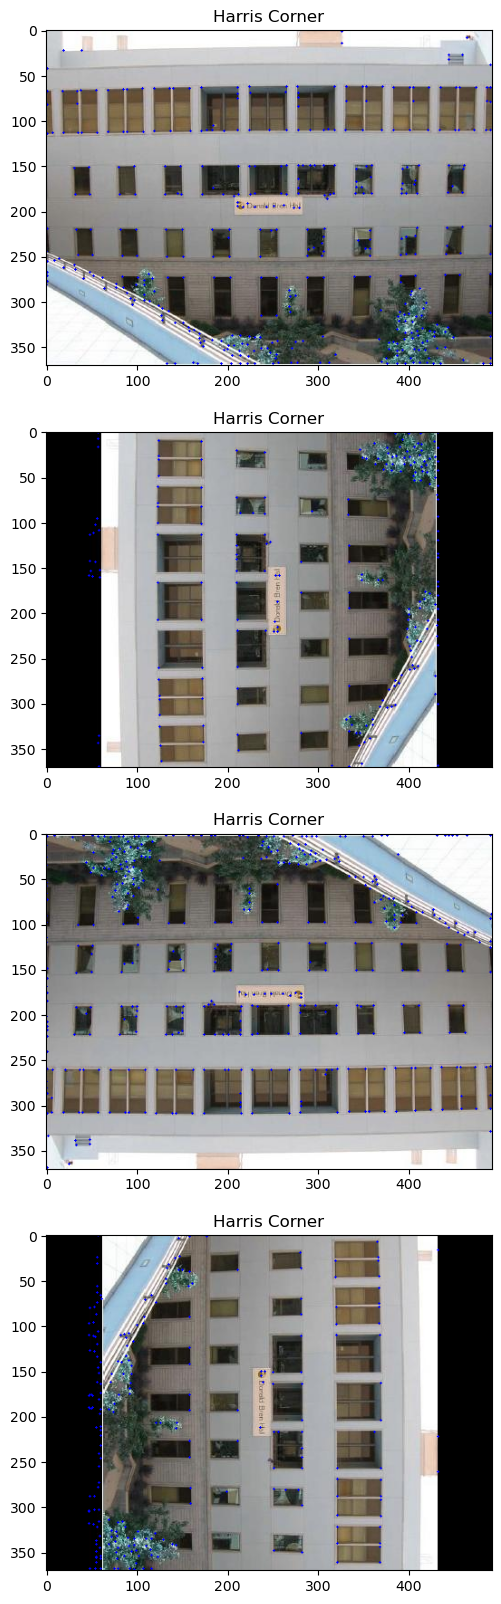

In [145]:
#Apply Harris cprner detection to the result
    # def save(self, dir="out_img/idw_max_3.jpg"):
    #     plt.imsave(dir, self.img)
def save(self,dir=1):
    plt.imsave("img"+str(dir)+".jpg", self)
save(pic1_cv2,1)
save(pic2_cv2,2)
save(pic3_cv2,3)
save(pic4_cv2,4)

# plt.imsave("img"+str(1),pic1_cv2)
# perfrom non-maximum suppresion
Ix2,Iy2,Ixy=calculateM(2,"img1.jpg")

R1 = my_harris2(Ix2,Iy2,Ixy,thresh,0.01)

Ix2,Iy2,Ixy=calculateM(2,"img2.jpg")
R2 = my_harris2(Ix2,Iy2,Ixy,thresh,0.01)

Ix2,Iy2,Ixy=calculateM(2,"img3.jpg")
R3 = my_harris2(Ix2,Iy2,Ixy,thresh,0.01)

Ix2,Iy2,Ixy=calculateM(2,"img4.jpg")
R4 = my_harris2(Ix2,Iy2,Ixy,thresh,0.01)

R1_final=non_maximum_suppression(R1,7)
R2_final=non_maximum_suppression(R2,7)
R3_final=non_maximum_suppression(R3,7)
R4_final=non_maximum_suppression(R4,7)

bw=plt.imread("img1.jpg")
result1 = bw.copy()
#thresholding for an optimal value
result1[R1_final>0.0*R1_final.max()]=[0,0,255]

bw=plt.imread("img2.jpg")
result2 = bw.copy()
#thresholding for an optimal value
result2[R2_final>0.0*R2_final.max()]=[0,0,255]

bw=plt.imread("img3.jpg")
result3 = bw.copy()
#thresholding for an optimal value
result3[R3_final>0.0*R3_final.max()]=[0,0,255]

bw=plt.imread("img4.jpg")
result4 = bw.copy()
#thresholding for an optimal value
result4[R4_final>0.0*R4_final.max()]=[0,0,255]

corner_num=[0,0,0,0]

bw=plt.imread("img1.jpg")
height=bw.shape[0]
width=bw.shape[1]
bw1_copy=bw.copy()
#  draw circle around the corners
for x in range(height):
    for y in range(width):
        if R1_final[x, y] != 0:
            corner_num[0]+=1
            cv2.circle(bw1_copy, (y, x), 1, (0, 0, 255), -1)

bw=plt.imread("img2.jpg")
height=bw.shape[0]
width=bw.shape[1]
bw2_copy=bw.copy()
#  draw circle around the corners
for x in range(height):
    for y in range(width):
        if R2_final[x, y] != 0:
            corner_num[1]+=1
            cv2.circle(bw2_copy, (y, x), 1, (0, 0, 255), -1)

bw=plt.imread("img3.jpg")
height=bw.shape[0]
width=bw.shape[1]
bw3_copy=bw.copy()
#  draw circle around the corners
for x in range(height):
    for y in range(width):
        if R3_final[x, y] != 0:
            corner_num[2]+=1
            cv2.circle(bw3_copy, (y, x), 1, (0, 0, 255), -1)

bw=plt.imread("img4.jpg")
height=bw.shape[0]
width=bw.shape[1]
bw4_copy=bw.copy()
#  draw circle around the corners
for x in range(height):
    for y in range(width):
        if R4_final[x, y] != 0:
            corner_num[3]+=1
            cv2.circle(bw4_copy, (y, x), 1, (0, 0, 255), -1)

print(corner_num)

plt.figure(figsize=(20, 20))

plt.subplot(4, 1, 1)
plt.title("Harris Corner")
plt.imshow(bw1_copy,cmap='gray')

plt.subplot(4, 1, 2)
plt.title("Harris Corner")
plt.imshow(bw2_copy,cmap='gray')

plt.subplot(4, 1, 3)
plt.title("Harris Corner")
plt.imshow(bw3_copy,cmap='gray')

plt.subplot(4, 1, 4)
plt.title("Harris Corner")
plt.imshow(bw4_copy,cmap='gray')




In [149]:
# compare the 4 images
comparison=np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if R4_final[x, y] != 0:
            cv2.circle(bw4_copy, (y, x), 1, (0, 0, 255), -1)
plt.imshow()

In [ ]:
#one way from ChatGPT

# def inverse_warp_image(image, inverse_transform, output_size):
#     """
#     使用反转的变换矩阵逆向变形图像。

#     参数：
#     - image：输入图像（numpy数组）。
#     - inverse_transform：反转的变换矩阵（3x3）。
#     - output_size：输出图像的大小（元组）。

#     返回：
#     - 变形后的图像（numpy数组）。
#     """

#     # 获取输出图像的宽度和高度
#     out_width, out_height = output_size

#     # 创建输出像素坐标的网格
#     out_grid_x, out_grid_y = np.meshgrid(np.arange(out_width), np.arange(out_height))
#     out_grid = np.stack([out_grid_x.flatten(), out_grid_y.flatten(), np.ones(out_width*out_height)], axis=1)

    # # 将输出像素坐标变换回输入像素坐标
    # in_grid = np.dot(out_grid, inverse_transform.T)
    # in_grid_x = in_grid[:, 0] / in_grid[:, 2]
    # in_grid_y = in_grid[:, 1] / in_grid[:, 2]

    # # 使用双线性插值插值像素值
    # warped_image = np.zeros((out_height, out_width, image.shape[2]), dtype=np.uint8)

    # print(warped_image.shape)
    # for c in range(image.shape[2]):
    #     warped_image[..., c] = bilinear_interpolation(image[..., c], in_grid_x, in_grid_y, image.shape[1], image.shape[0])

    # return warped_image

def inverse_warp_image(image, inverse_transform, output_size):
    rows, cols, depth = output_size
    inverse_warp_pic = np.zeros(output_size)
    pts1 = np.float32([[50, 50],[200, 50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,250]])
    
    # transform matrix
    M = cv2.getAffineTransform(pts1, pts2)
    M = np.asmatrix(M)

    for d in range(depth):
        for v in range(rows):
            for u in range(cols):
                x = int(round(M[0,0]*u + M[0,1]*v + M[0,2]))
                y = int(round(M[1,0]*u + M[1,1]*v + M[1,2]))
                if x < 0 or x >= cols or y < 0 or y >= rows:
                    continue
                inverse_warp_pic[y,x,d] = img[v,u,d]

def bilinear_interpolation(image, x, y, width, height):
    """
    执行双线性插值以计算像素值。

    参数：
    - image：输入图像（numpy数组）。
    - x：要插值的点的X坐标。
    - y：要插值的点的Y坐标。
    - width：图像的宽度。
    - height：图像的高度。

    返回：
    - 插值的像素值。
    """

    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    x0 = np.clip(x0, 0, width - 1)
    x1 = np.clip(x1, 0, width - 1)
    y0 = np.clip(y0, 0, height - 1)
    y1 = np.clip(y1, 0, height - 1)

    Ia = image[y0, x0]
    Ib = image[y1, x0]
    Ic = image[y0, x1]
    Id = image[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    interpolated_values = wa * Ia + wb * Ib + wc * Ic + wd * Id
    print(interpolated_values.shape)
    return interpolated_values.astype(np.uint8)


# 示例用法：
# 加载图像
image = cv2.imread('Task1/Harris-1.jpg')

# 定义反转的变换矩阵（示例）
inverse_transform = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # 示例中的单位矩阵

# 定义输出大小（示例）
output_size = (image.shape[1], image.shape[0])  # 与输入图像大小相同

# 变形图像
warped_image = inverse_warp_image(image, inverse_transform, output_size)

# 显示结果
cv2.imshow('Warped Image', warped_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [63]:
#one way from https://github.com/insaneyilin/ImageWarping/blob/master/image_warping/idw_image_warping.cpp

class IDWImageWarping:
    def __init__(self):
        pass

    def get_transformed_point(self, pt):
        num_ctrl_pts = len(self.source_points)
        trans_pt = np.zeros(2)
        self.calc_weights(pt)
        for i in range(num_ctrl_pts):
            trans_pt += self.weights[i] * (self.target_points[i] + 
                                           np.dot(self.local_trans_mat_list[i], (pt - self.source_points[i])))
        return trans_pt

    def solve_transformations(self):
        self.solve_optimal_local_transformations()

    def calc_weights(self, pt):
        num_ctrl_pts = len(self.source_points)
        weights_sum = 0.0
        self.weights = []
        for i in range(num_ctrl_pts):
            w = np.power(self.distance(pt, self.source_points[i]), -2.0)
            self.weights.append(w)
            weights_sum += w
        eps = 1e-5
        self.weights = [w / weights_sum for w in self.weights]

    def solve_optimal_local_transformations(self):
        num_ctrl_pts = len(self.source_points)
        self.local_trans_mat_list = []
        for i in range(num_ctrl_pts):
            self.local_trans_mat_list.append(np.eye(2))
        if num_ctrl_pts == 1:
            return
        else:
            for i in range(num_ctrl_pts):
                coeff_mat = np.zeros((2, 2))
                b_vec_1 = np.zeros(2)
                b_vec_2 = np.zeros(2)
                for j in range(num_ctrl_pts):
                    if i == j:
                        continue
                    sigma = np.power(self.distance(self.source_points[i], self.source_points[j]), -2.0)
                    coeff_mat[0, 0] += sigma * (self.source_points[j][0] - self.source_points[i][0]) ** 2
                    coeff_mat[0, 1] += sigma * (self.source_points[j][0] - self.source_points[i][0]) * (self.source_points[j][1] - self.source_points[i][1])
                    coeff_mat[1, 0] += sigma * (self.source_points[j][1] - self.source_points[i][1]) * (self.source_points[j][0] - self.source_points[i][0])
                    coeff_mat[1, 1] += sigma * (self.source_points[j][1] - self.source_points[i][1]) ** 2

                    b_vec_1[0] += sigma * (self.source_points[j][0] - self.source_points[i][0]) * (self.target_points[j][0] - self.target_points[i][0])
                    b_vec_1[1] += sigma * (self.source_points[j][1] - self.source_points[i][1]) * (self.target_points[j][0] - self.target_points[i][0])
                    b_vec_2[0] += sigma * (self.source_points[j][0] - self.source_points[i][0]) * (self.target_points[j][1] - self.target_points[i][1])
                    b_vec_2[1] += sigma * (self.source_points[j][1] - self.source_points[i][1]) * (self.target_points[j][1] - self.target_points[i][1])
                b_vec_1 = np.linalg.solve(coeff_mat, b_vec_1)
                b_vec_2 = np.linalg.solve(coeff_mat, b_vec_2)
                self.local_trans_mat_list[i][0, 0] = b_vec_1[0]
                self.local_trans_mat_list[i][0, 1] = b_vec_1[1]
                self.local_trans_mat_list[i][1, 0] = b_vec_2[0]
                self.local_trans_mat_list[i][1, 1] = b_vec_2[1]

    def distance(self, pt1, pt2):
        return np.linalg.norm(pt1 - pt2)

# Example usage:
# Initialize an instance
idw = IDWImageWarping()

# Set control points and their corresponding target points
idw.source_points = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
idw.target_points = np.array([[0, 0], [2, 0], [0, 2], [2, 2]])

# Solve transformations
idw.solve_transformations()

# Get transformed point
transformed_point = idw.get_transformed_point(np.array([0.5, 0.5]))
print("Transformed Point:", transformed_point)


Transformed Point: [1. 1.]


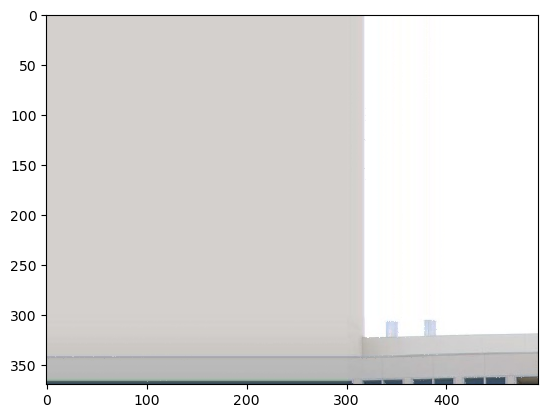

In [62]:
#one way from https://github.com/cyzkrau/DIP_2021f/blob/master/Image_warping/code.py
# from tqdm import tqdm


class point:
    def __init__(self, position, dir=None) -> None:
        self.position = np.array(position)
        self.point_at = self.position if dir is None else np.array(dir)
        self.T = np.array([[1, 0], [0, 1]])

    def is_fix(self):
        return (self.point_at == self.position).all()


class idw_model:

    def __init__(self, img="imgs/demo.jpeg", mu=1) -> None:
        if isinstance(img, str):
            img = plt.imread(img)
        self.img = img
        self.shape = np.array(img.shape[:-1])
        self.points = []
        self.mu = mu

    def norm(self, p, n=1):
        if n == 1:
            return np.sum(np.abs(p))
        elif n == 2:
            return np.max(np.abs(p))
        return np.sqrt(sum(p**2))

    def change(self, x, y):
        self.points.append(point([y[1], y[0]], [x[1], x[0]]))

    def fix_point(self, x):
        self.change(x, x)

    def fix_edge(self):
        for i in [0, self.shape[0]-1]:
            for j in [0, self.shape[1]-1]:
                self.fix_point([i, j])

    def caul(self, posi):
        q, su = [0, 0], 0
        for k in self.points:
            if (k.position == posi).all():
                return k.point_at
            sigma = 1./self.norm(k.position-posi)
            sigma = sigma**self.mu
            q += sigma*(k.point_at+posi-k.position)
            su += sigma
        return q/su


    # def caul(self, posi):
    #     x, y = posi[0], posi[1]

    #     # 取整得到左上角坐标
    #     x0, y0 = int(x), int(y)

    #     # 计算权重
    #     dx = x - x0
    #     dy = y - y0

    #     # 确保点在图像范围内
    #     x0 = max(0, min(x0, self.shape[0] - 2))
    #     y0 = max(0, min(y0, self.shape[1] - 2))

    #     # 计算双线性插值
    #     interpolated_value = (1 - dx) * (1 - dy) * self.img[x0, y0] + \
    #                         dx * (1 - dy) * self.img[x0 + 1, y0] + \
    #                         (1 - dx) * dy * self.img[x0, y0 + 1] + \
    #                         dx * dy * self.img[x0 + 1, y0 + 1]

    #     return interpolated_value


    def to_legal(self, posi):
        x, y = posi[0], posi[1]
        x = 0 if x < 0 else x
        y = 0 if y < 0 else y
        x = self.shape[0]-1 if x >= self.shape[0] else int(x)
        y = self.shape[1]-1 if y >= self.shape[1] else int(y)
        return self.img[x][y]

    def work(self):
        if self.points == []:
            return
        ansimg = [[] for i in range(self.shape[0])]
        
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                ansimg[i].append(self.to_legal(self.caul([i, j])))
        self.img = np.array(ansimg)

    def show(self):
        plt.imshow(self.img)
        plt.show()

    def save(self, dir="out_img/idw_max_3.jpg"):
        plt.imsave(dir, self.img)


class rbf_model:

    # def __init__(self, img="imgs/demo.jpeg", sigma=1) -> None:
    def __init__(self, img="Task1/Harris-1.jpg", sigma=1) -> None:
        if isinstance(img, str):
            img = plt.imread(img)/255
        self.img = img
        self.shape = np.array(img.shape[:-1])
        self.points = []
        self.sigma = sigma

    def norm(self, p, n=1):
        if n == 1:
            return np.sum(np.abs(p))
        elif n == 2:
            return np.max(np.abs(p))
        return np.sqrt(sum(p**2))

    def change(self, x, y):
        self.points.append(point(y, np.array(x)-y))

    def rbf_function(self, x, sigma):
        return np.exp(-x*x/(sigma*sigma))

    def caul(self, posi):
        now_posi = posi.copy()
        for k in self.points:
            sigma = self.norm(k.point_at)*self.sigma
            distance = self.norm(k.position-posi)
            now_posi += self.rbf_function(distance, sigma)*k.point_at
        return now_posi

    def to_legal(self, posi):
        x, y = posi[0], posi[1]
        x = 0 if x < 0 else x
        y = 0 if y < 0 else y
        x = self.shape[0]-1 if x >= self.shape[0] else int(x)
        y = self.shape[1]-1 if y >= self.shape[1] else int(y)
        return self.img[x][y]

    def work(self):
        ansimg = [[] for i in range(self.shape[0])]
        print(self.shape)
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                ansimg[i].append(self.to_legal(self.caul([i, j])))
        self.img = np.array(ansimg)

    def show(self):
        plt.imshow(self.img)
        plt.show()

    def save(self, dir="out_img/rbf_1.jpg"):
        plt.imsave(dir, self.img)


if __name__ == "__main__":
    a = idw_model( img="Task1/Harris-1.jpg")
    
    a.change([200, 200], [500, 500])
    a.work()
    a.show()

In [58]:
#one way from https://github.com/sumeyye-agac/homography-and-image-stitching-from-scratch/blob/main/image_stitching.py
# 1. Selecting corresponding points
def selectingPoints(input_path_image_source, input_path_image_dest, image_source, image_dest, points_source, points_dest, number_of_points, manual_selection):

    if manual_selection == True:
        plt.imshow(image_source)
        selected_point_pairs_im_source = plt.ginput(number_of_points, timeout=3000, show_clicks=True)
        np.save(input_path_image_source, selected_point_pairs_im_source)
        plt.close()

        plt.imshow(image_dest)
        selected_point_pairs_im_dest = plt.ginput(number_of_points, timeout=3000, show_clicks=True)
        np.save(input_path_image_dest, selected_point_pairs_im_dest)
        plt.close()
    else:
        selected_point_pairs_im_source = np.load(points_source)
        selected_point_pairs_im_dest = np.load(points_dest)

    return selected_point_pairs_im_source, selected_point_pairs_im_dest


# 2. Homography estimation
def computeH(points_im1, points_im2):
    A = []
    number_of_points = len(points_im1)
    for i in range(number_of_points):
        x_1, y_1 = points_im1[i][0], points_im1[i][1] # x, y
        x_2, y_2 = points_im2[i][0], points_im2[i][1] # x' and y'
        A.append([x_1, y_1, 1, 0, 0, 0, -x_1*x_2, -y_1*x_2, -x_2])
        A.append([0, 0, 0, x_1, y_1, 1, -x_1*y_2, -y_1*y_2, -y_2])
    U, S, V = np.linalg.svd(np.asarray(A))
    H = V[-1, :]/V[-1, -1]
    homography = H.reshape(3, 3)
    print("Homography matrix is calculated.")
    print("Homography: ", "\n", homography)
    return homography
# Homogeneous coordinate calculation
def homogeneous_coordinate(coordinate):
    x = coordinate[0]/coordinate[2]
    y = coordinate[1]/coordinate[2]
    return x, y


# 3. Backward image warping
def warp(image, homography):
    print("Warping is started.")

    image_array = np.array(image)
    row_number, column_number = int(image_array.shape[0]), int(image_array.shape[1])

    up_left_cor_x, up_left_cor_y = homogeneous_coordinate(np.dot(homography, [[0],[0],[1]]))
    up_right_cor_x, up_right_cor_y = homogeneous_coordinate(np.dot(homography, [[column_number-1],[0],[1]]))
    low_left_cor_x, low_left_cor_y = homogeneous_coordinate(np.dot(homography, [[0],[row_number-1],[1]]))
    low_right_cor_x, low_right_cor_y = homogeneous_coordinate(np.dot(homography, [[column_number-1],[row_number-1],[1]]))

    x_values = [up_left_cor_x, up_right_cor_x, low_right_cor_x, low_left_cor_x]
    y_values = [up_left_cor_y, up_right_cor_y, low_left_cor_y,  low_right_cor_y]
    print("x_values: ", x_values, "\n y_values: ", y_values)

    offset_x = math.floor(min(x_values))
    offset_y = math.floor(min(y_values))

    # offset_x = int(min(x_values))
    # offset_y = int(min(y_values))
    print("offset_x: ", offset_x, "\t size_y: ", offset_x)

    max_x = math.ceil(max(x_values))
    max_y = math.ceil(max(y_values))

    # # 寻找最大值并向上取整
    # max_x = max(x_values)
    # if max_x > int(max_x):
    #     max_x = int(max_x) + 1
    # else:
    #     max_x = int(max_x)

    # max_y = max(y_values)
    # if max_y > int(max_y):
    #     max_y = int(max_y) + 1
    # else:
    #     max_y = int(max_y)



    size_x = max_x - offset_x
    size_y = max_y - offset_y
    print("size_x: ", size_x, "\t size_y: ", size_y)

    homography_inverse = np.linalg.inv(homography)
    print("Homography inverse: ", "\n", homography_inverse)

    result = np.zeros((size_y, size_x, 3))

    for x in range(size_x):
        for y in range(size_y):
            point_xy = homogeneous_coordinate(np.dot(homography_inverse, [[x+offset_x], [y+offset_y], [1]]))
            point_x = int(point_xy[0])
            point_y = int(point_xy[1])

            if (point_x >= 0 and point_x < column_number and point_y >= 0 and point_y < row_number):
                result[y, x, :] = image_array[point_y, point_x, :]

    print("Warping is completed.")
    return result, offset_x, offset_y


# 4. Image stitching using 3 images
def blend3images(left, middle, right, left_middle_offset_x, left_middle_offset_y, right_middle_offset_x, right_middle_offset_y):
    print("Blending three images is started.")

    #left = np.array(left)
    #middle = np.array(middle)
    #right = np.array(right)

    rows_left, columns_left = int(left.shape[0]), int(left.shape[1])
    rows_middle, columns_middle = int(middle.shape[0]), int(middle.shape[1])
    rows_right, columns_right = int(right.shape[0]), int(right.shape[1])

    print("Column number of left: ", columns_left, "\t Row number of base: ", rows_left)
    print("Column number of middle: ", columns_middle, "\t Row number of middle: ", rows_middle)
    print("Column number of right: ", columns_right, "\t Row number of right: ", rows_right)

    x_min = min([left_middle_offset_x, right_middle_offset_x, 0])
    x_max = max([left_middle_offset_x+columns_left, right_middle_offset_x+columns_right, columns_middle])

    y_min = min([left_middle_offset_y, right_middle_offset_y, 0])
    y_max = max([rows_left+left_middle_offset_y, rows_right+right_middle_offset_y, rows_middle])

    size_x = x_max - x_min
    size_y = y_max - y_min

    print("size_x: ", size_x, "\t size_y: ", size_y)
    blending = np.zeros((size_y, size_x, 3))

    #left
    blending[:rows_left, :columns_left, :] = left[:, :, :]

    #right
    blending[size_y-rows_right:, size_x-columns_right:, :] = right[:, :, :]
    blending[size_y - rows_right:, size_x - columns_right:, :] = np.where(
        blending[size_y - rows_right:, size_x - columns_right:, :] == [0, 0, 0],
        right[:, :, :], blending[size_y - rows_right:, size_x - columns_right:, :])

    #middle
    #blending[-left_middle_offset_y:rows_middle-left_middle_offset_y, -left_middle_offset_x:columns_middle-left_middle_offset_x, :] = middle[:, :, :]

    blending[-left_middle_offset_y:rows_middle-left_middle_offset_y, -left_middle_offset_x:columns_middle-left_middle_offset_x, :] = \
       np.where(np.mean(middle[:2], axis=0) <
                np.mean(blending[-left_middle_offset_y:rows_middle-left_middle_offset_y, -left_middle_offset_x:columns_middle-left_middle_offset_x, :][:2], axis=0),
                blending[-left_middle_offset_y:rows_middle-left_middle_offset_y, -left_middle_offset_x:columns_middle-left_middle_offset_x, :], middle)

    print("Blending is completed.")
    return blending



In [42]:
# warpped_image,offset_x,offset_y=warp(original_image)
# plt.imshow(warpped_image)
# Main function
def main():

    # input_path_image_source1 = "images\paris_a.jpg"
    # input_path_image_source2 = "images\paris_c.jpg"
    # input_path_image_dest = "images\paris_b.jpg" # base
    input_path_image_source1 = "Task1/Harris-1.jpg"
    input_path_image_source2 = "Task1/Harris-1.jpg"
    input_path_image_dest = "Task1/Harris-1.jpg"
    image_source1 = Image.open(input_path_image_source1)
    image_source2 = Image.open(input_path_image_source2)
    image_dest = Image.open(input_path_image_dest)

    points_source1 = "points/points_paris_a_-paris_ab.npy"
    points_dest1 = "points/points_paris_b_-paris_ab.npy"
    points_source2 = "points/points_paris_c_-paris_bc.npy"
    points_dest2 = "points/points_paris_b_-paris_bc.npy"

    number_of_points = 10
    manual_selection = False

    # paris_a and paris_b
    selected_point_pairs_im_source1, selected_point_pairs_im_dest1 = selectingPoints(
        input_path_image_source1, input_path_image_dest, image_source1, image_dest,
        points_source1, points_dest1, number_of_points, manual_selection)



    homography1 = computeH(np.array(selected_point_pairs_im_source1), np.array(selected_point_pairs_im_dest1))

    warped_image_source1, source1_offset_x, source1_offset_y = warp(image_source1, homography1)

    image = Image.fromarray(warped_image_source1.astype('uint8'), 'RGB')
    # image.save("warped_" + input_path_image_source1[-11:])

    # paris_b and paris_c
    selected_point_pairs_im_source2, selected_point_pairs_im_dest2 = selectingPoints(
        input_path_image_source2, input_path_image_dest, image_source2, image_dest,
        points_source2, points_dest2, number_of_points, manual_selection)
    homography2 = computeH(np.array(selected_point_pairs_im_source2), np.array(selected_point_pairs_im_dest2))
    warped_image_source2, source2_offset_x, source2_offset_y = warp(image_source2, homography2)
    image = Image.fromarray(warped_image_source2.astype('uint8'), 'RGB')
    image.save("warped_" + input_path_image_source2[-11:])

    # Stitching 3 images
    result_blended = blend3images(warped_image_source1, np.array(image_dest), warped_image_source2,
                                  source1_offset_x, source1_offset_y, source2_offset_x, source2_offset_y)

    # Stitching 2 images
    #result_blended = blend2images(warped_image_source1, np.array(image_dest), source1_offset_x, source1_offset_y)

    image = Image.fromarray(result_blended.astype('uint8'), 'RGB')
    image.save("blended_image.jpg")
    print("Blended image is generated.")

# Call main function
if __name__ == '__main__':
    main()

Homography matrix is calculated.
Homography:  
 [[ 1.96691871e+00 -1.17559787e-01 -5.59240978e+02]
 [ 4.81475201e-01  1.59446665e+00 -1.93612606e+02]
 [ 1.59303521e-03 -1.79643320e-04  1.00000000e+00]]
Warping is started.
x_values:  [array([-559.24097798]), array([228.10044096]), array([211.63136647]), array([-645.40328053])] 
 y_values:  [array([-193.61260557]), array([24.01088074]), array([422.77035144]), array([367.82614958])]
offset_x:  -646 	 size_y:  -646
size_x:  875 	 size_y:  617
Homography inverse:  
 [[ 3.36901347e-01  4.70944166e-02  1.97527111e+02]
 [-1.70624596e-01  6.17303831e-01  2.40975370e+01]
 [-5.67347276e-04  3.58714457e-05  6.89661318e-01]]


/var/folders/wc/965rbb8j6jvbfr70gnjt5jzh0000gn/T/ipykernel_64165/1337526874.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  offset_x = math.floor(min(x_values))
/var/folders/wc/965rbb8j6jvbfr70gnjt5jzh0000gn/T/ipykernel_64165/1337526874.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  offset_y = math.floor(min(y_values))
/var/folders/wc/965rbb8j6jvbfr70gnjt5jzh0000gn/T/ipykernel_64165/1337526874.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  max_x = 

Warping is completed.
Homography matrix is calculated.
Homography:  
 [[ 4.87205344e-01 -1.25500862e-01  2.46575390e+02]
 [-1.95562408e-01  6.69094574e-01  7.80722382e+01]
 [-6.55667769e-04 -3.78970038e-04  1.00000000e+00]]
Warping is started.
x_values:  [array([246.5753903]), array([716.43823494]), array([816.538837]), array([232.82361349])] 
 y_values:  [array([78.07223818]), array([-26.47068893]), array([377.79961264]), array([425.37241119])]
offset_x:  232 	 size_y:  232
size_x:  585 	 size_y:  453
Homography inverse:  
 [[ 1.55701902e+00  7.14375125e-02 -3.89499859e+02]
 [ 3.21736591e-01  1.44602867e+00 -1.92227021e+02]
 [ 1.14281572e-03  5.94840816e-04  6.71769215e-01]]
Warping is completed.
Blending three images is started.
Column number of left:  875 	 Row number of base:  617
Column number of middle:  492 	 Row number of middle:  370
Column number of right:  585 	 Row number of right:  453
size_x:  1463 	 size_y:  620
Blending is completed.
Blended image is generated.


In [39]:
#one way from https://medium.com/swlh/image-processing-with-python-image-warping-using-homography-matrix-22096734f09a
palawan = plt.imread('Task1/Harris-1.jpg')
plt.imshow(palawan)

SyntaxError: invalid syntax (958205805.py, line 4)

In [40]:
area_of_interest = [(500, 600),
                    (3220, 1950),
                    (3220, 2435),
                    (500, 3100)]
area_of_projection = [(100, 1000),
                      (3400, 1000),
                      (3400, 2600),
                      (100, 2600)]


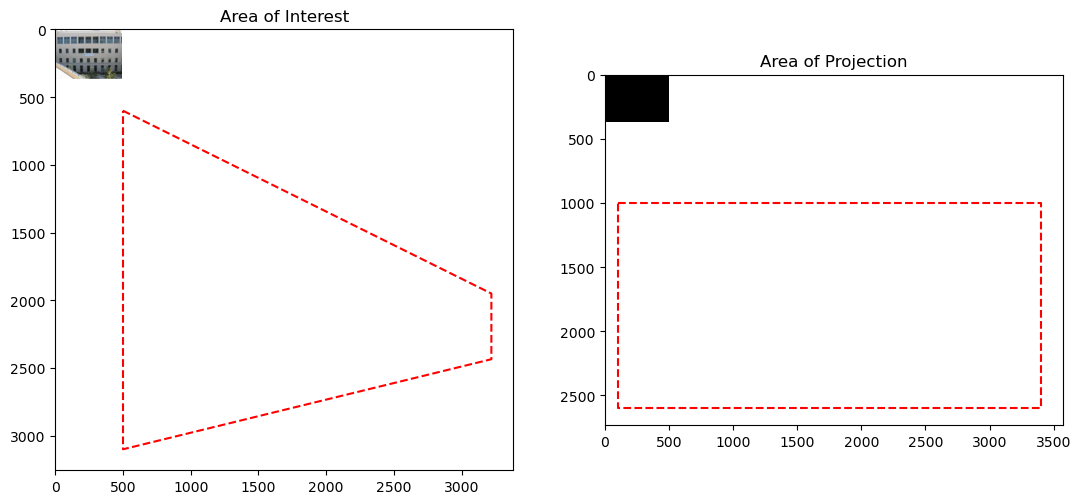

In [15]:
def project_planes(image, src, dst):
    x_src = [val[0] for val in src] + [src[0][0]]
    y_src = [val[1] for val in src] + [src[0][1]]
    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]
    
    fig, ax = plt.subplots(1,2, figsize=(13,6))
    
    new_image = image.copy() 
    projection = np.zeros_like(new_image)
    ax[0].imshow(new_image)
    ax[0].plot(x_src, y_src, 'r--')
    ax[0].set_title('Area of Interest')
    ax[1].imshow(projection)
    ax[1].plot(x_dst, y_dst, 'r--')
    ax[1].set_title('Area of Projection')
project_planes(palawan, area_of_interest, area_of_projection)

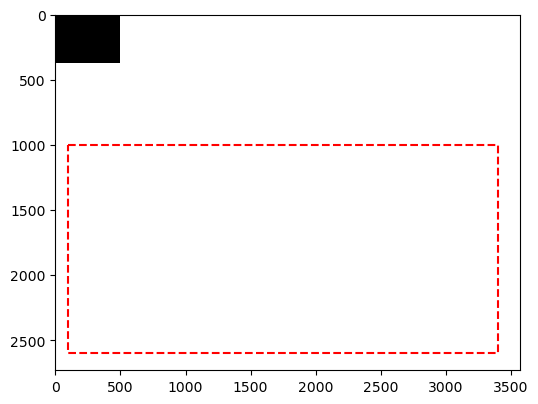

In [18]:
def project_transform(image, src, dst):
    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]
    
    tform = transform.estimate_transform('projective', 
                                         np.array(src), 
                                         np.array(dst))
    transformed = transform.warp(image, tform.inverse)
    
    plt.figure(figsize=(6,6))
    plt.imshow(transformed)
    plt.plot(x_dst, y_dst, 'r--')
project_transform(palawan, area_of_interest, area_of_projection)

(370, 492, 3)
(182040,)


ValueError: could not broadcast input array from shape (182040,) into shape (370,492)